In [1]:
# Import libraries
import os
import glob
from osgeo import gdal
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.ndimage
import pandas as pd
import datetime as dt
import rasterio as rio
import re
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
from pyhdf.SD import SD, SDC
import pprint

In [2]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\MODIS_BA"   # I should change this so I can work from github?
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [3]:
# select first MODIS file
MODISFiles = glob.glob('*h20v07*') 
print(len(MODISFiles))
print(MODISFiles[0])

217
MCD64A1.A2002001.h20v07.006.2017012181506.hdf


In [4]:
# date range of tile
productId1 = MODISFiles[0].split('.')[0]                                          # First: product name
yeardoy1 = MODISFiles[0].split(productId1 + '.A')[1].split('.')[0]                 # Julian date
date1 = dt.datetime.strptime(yeardoy1, '%Y%j').strftime('%d/%m/%Y')                # Convert YYYYDDD to DD/MM/YYYY

productId2 = MODISFiles[-1].split('.')[0]                                         # First: product name
yeardoy2 = MODISFiles[-1].split(productId1 + '.A')[1].split('.')[0]                # Julian date
date2 = dt.datetime.strptime(yeardoy2, '%Y%j').strftime('%d/%m/%Y')                # Convert YYYYDDD to DD/MM/YYYY

print('First date of observation: {})'.format(date1))
print('Last date of observation:  {})'.format(date2))

First date of observation: 01/01/2002)
Last date of observation:  01/01/2020)


In [5]:
import gdal
from gdalconst import *
filename= MODISFiles[0]
dataset = gdal.Open(filename,GA_ReadOnly)
subdataset = dataset.GetSubDatasets()[1]
print(type(dataset))
print(type(subdataset))

<class 'osgeo.gdal.Dataset'>
<class 'tuple'>


In [6]:
# Print all of the subdatasets in the file - interested in Burn Date
with rio.open(MODISFiles[0]) as dataset:
    crs = dataset.read_crs()
    for name in dataset.subdatasets:
        print(name)

HDF4_EOS:EOS_GRID:MCD64A1.A2002001.h20v07.006.2017012181506.hdf:MOD_Grid_Monthly_500m_DB_BA:Burn Date
HDF4_EOS:EOS_GRID:MCD64A1.A2002001.h20v07.006.2017012181506.hdf:MOD_Grid_Monthly_500m_DB_BA:Burn Date Uncertainty
HDF4_EOS:EOS_GRID:MCD64A1.A2002001.h20v07.006.2017012181506.hdf:MOD_Grid_Monthly_500m_DB_BA:QA
HDF4_EOS:EOS_GRID:MCD64A1.A2002001.h20v07.006.2017012181506.hdf:MOD_Grid_Monthly_500m_DB_BA:First Day
HDF4_EOS:EOS_GRID:MCD64A1.A2002001.h20v07.006.2017012181506.hdf:MOD_Grid_Monthly_500m_DB_BA:Last Day


C:\Users\samgr\miniconda3\envs\GDAL_test\lib\site-packages\rasterio\__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
file_name = MODISFiles[0]
file = SD(file_name, SDC.READ)  # SDC means scientific dataset  

# print datasets in file
datasets_dic = file.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
    print(idx,sds)

0 Burn Date
1 Burn Date Uncertainty
2 QA
3 First Day
4 Last Day


In [8]:
# get data for Burn Date - can change this to get data for other simply by changing the index number
sds_obj = file.select(0) # select sds

data = sds_obj.get() # get sds data
print(data)
# print attributes to see scale factor and add_offset
import pprint
pprint.pprint(sds_obj.attributes())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
{'_FillValue': -1,
 'long_name': 'ordinal day of burn',
 'valid_range': [0, 366],
 'water': -2}


In [9]:
# this shows where fire burns for certain day 
result = np.where(data > 0)
print('Tuple of arrays returned :{} '.format(result))

# somehow get 2 different arrays?

Tuple of arrays returned :(array([1547, 1547, 1547, ..., 2399, 2399, 2399], dtype=int64), array([1978, 1979, 1980, ..., 2368, 2369, 2370], dtype=int64)) 


In [10]:
# create a new array
blanks = np.zeros((2400, 2400))
print(blanks.shape)

(2400, 2400)


In [11]:
NUM = 0
for i in MODISFiles:
    productId = MODISFiles[NUM].split('.')[0]                                          # First: product name
    yeardoy = MODISFiles[NUM].split(productId1 + '.A')[1].split('.')[0]                 # Julian date
    date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y')                # Convert YYYYDDD to DD/MM/YYYY
    tiles_id = MODISFiles[NUM].split(yeardoy + '.')[1].split('.006')[0]               # Second: tile id
    unknown_format = MODISFiles[NUM].split(tiles_id +'.006.')[1].split('.hdf')[0]     # Third: date (DD/MM/YYYY)
    
    print('Product name: {}       Observation date: {}       tiles id: {}      unknown: {}'.format(productId, date, tiles_id, unknown_format))
    NUM += 1


Product name: MCD64A1       Observation date: 01/01/2002       tiles id: h20v07      unknown: 2017012181506
Product name: MCD64A1       Observation date: 01/02/2002       tiles id: h20v07      unknown: 2017012210538
Product name: MCD64A1       Observation date: 01/03/2002       tiles id: h20v07      unknown: 2017012225857
Product name: MCD64A1       Observation date: 01/04/2002       tiles id: h20v07      unknown: 2017013011053
Product name: MCD64A1       Observation date: 01/05/2002       tiles id: h20v07      unknown: 2017013025243
Product name: MCD64A1       Observation date: 01/06/2002       tiles id: h20v07      unknown: 2017013052003
Product name: MCD64A1       Observation date: 01/07/2002       tiles id: h20v07      unknown: 2017013074204
Product name: MCD64A1       Observation date: 01/08/2002       tiles id: h20v07      unknown: 2017013132434
Product name: MCD64A1       Observation date: 01/09/2002       tiles id: h20v07      unknown: 2017013170755
Product name: MCD64A1       

In [12]:
NUMBER = 0

for j in MODISFiles:
    filename= MODISFiles[NUMBER]
    dataset = gdal.Open(filename,GA_ReadOnly)
    subdataset = dataset.GetSubDatasets()[1]
    
    with rio.open(MODISFiles[NUMBER]) as dataset:
        crs = dataset.read_crs()
    
    file_name = MODISFiles[NUMBER]
    file = SD(file_name, SDC.READ)   
    
    datasets_dic = file.datasets()
    sds_obj = file.select(0)
    data = sds_obj.get() 
    result = np.where(data > 0)
    
    blanks[result] += 1
    
    NUMBER += 1

    # either all +=1 or all 0

In [14]:
print(blanks.max())
print(blanks.min())
mean = blanks.mean()
print(mean)
percent = mean / 270 *100


# saves the "blanks" as a csv file - remember I working with the array in the following script, not the csv
# np.savetxt("C:\\Users\\samgr\\OneDrive\\Desktop\\blanks1.csv", blanks, delimiter=",")

22.0
0.0
1.03729375


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 12.0, 14.0, 22.0]


Text(0, 0.5, 'Times burnt')

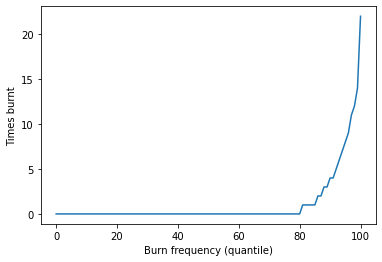

In [15]:
b = []

for i in range(0,101):
    b.append(np.quantile(blanks, i/100))

print(b)
plt.plot(b)
plt.xlabel("Burn frequency (quantile)")
plt.ylabel("Times burnt")


[0.0, 1.0, 4.0, 8.0, 22.0]


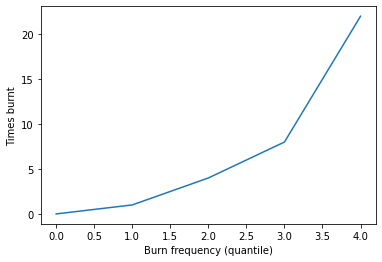

In [16]:
c = []

for i in range(0,101):
    if i == 80:
        c.append(np.quantile(blanks, i/100))
    if i == 85:
        c.append(np.quantile(blanks, i/100))
    if i == 90:
        c.append(np.quantile(blanks, i/100))
    if i == 95:
        c.append(np.quantile(blanks, i/100))
    if i == 100:
        c.append(np.quantile(blanks, i/100))
    # a.append(np.quantile(blanks, (i/100))

print(c)
plt.plot(c)
plt.xlabel("Burn frequency (quantile)")
plt.ylabel("Times burnt")
b = []



<ipython-input-19-815a860e1d9f>:20: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


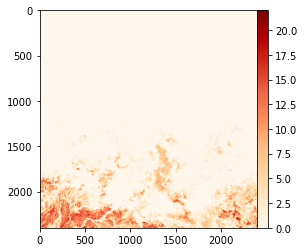

In [19]:
# need to change the bar to 

import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 

u = np.unique(blanks) 
bounds = np.concatenate(([blanks.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [blanks.max()])) 
  
# norm = colors.BoundaryNorm(bounds, len(bounds)) 
# color_map1 = ['#FFFAFA', '#FFA07A', '#FF6347', '#800000'] 
# color_map = colors.ListedColormap(color_map1)  
  
    
fig, axes = plt.subplots() 
img = axes.imshow(blanks, cmap = "OrRd", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
  
# color_bar.set_ticks(bounds[:-1]+np.diff(bounds)/2.) 
# color_bar.ax.set_yticklabels(color_map1) 
# color_bar.ax.tick_params(labelsize = 10) 
  
plt.show() 